In [175]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Nygaard TDM

In [176]:
U_0 = 10
z_0 = 0.0001
D = 100
z_H = 100
C_T = 0.8
s_x = 7
s_y = 7
s_d = s_x*D
s_c = s_y*D
kappa = 0.4
rho = 1.225

In [177]:
def calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c):

    c_t = (np.pi * C_T * D**2) / (8 * s_d * s_c)

    nu_star = 28 * np.sqrt(c_t)
    
    beta =  nu_star / (1 + nu_star)
    
    z_0WF = z_H * (1 + D / (2 * z_H))**beta * np.exp(-kappa * (c_t + (kappa / np.log((z_H / z_0) * (1 - D / (2 * z_H))**beta))**2)**-0.5)

    x = np.linspace(x_1, x_3-1, int(x_3-x_1))

    h_1 = np.full_like(x, np.nan, dtype=float)
    h_2 = np.full_like(x, np.nan, dtype=float)

    alpha_def = 0.8

    alpha_rec = 0.8

    h_1[x >= x_1] = (z_H/z_0WF + ((x[x >= x_1] - x_1) / z_0WF)**alpha_def) * z_0WF
    h_2[x >= x_2] =   (0/z_0WF + ((x[x >= x_2] - x_2) / z_0WF)**alpha_rec) * z_0WF

    U = np.full_like(x, np.nan, dtype=float)
    U[0] = U_0

    idx1 = (h_1 >= z_H)
    U[idx1] = U_0 * (np.log(h_1[idx1] / z_0) * np.log(z_H / z_0WF)) / (np.log(h_1[idx1] / z_0WF) * np.log(z_H / z_0))

    idx2 = (x >= x_2) & (h_2 >= z_H)
    U[idx2] = U_0 * (np.log(h_1[idx2] / z_0) * np.log(h_2[idx2] / z_0WF)) / (np.log(h_1[idx2] / z_0WF) * np.log(h_2[idx2] / z_0))

    for i in range(1, len(U)):
        if U[i] >= U_0 * 0.9999:
            U[i] = U_0 * 0.9999
        elif U[i] < 0:
            U[i] = 0


    plt.figure(figsize=(6, 4))
    plt.axhline(1.0, color='black', linestyle='--', linewidth=2, label=r'$U_0 \; / \; U_0 \; [-]$')
    plt.plot(x[idx1] / D, U[idx1] / U_0, color='#1f77b4', label=r'$U(x) \; / \; U_0 \; [-]$')
    plt.plot(x[idx2] / D, U[idx2] / U_0, color='#1f77b4', linewidth=0.5)
    plt.xlabel(r'$x \; / \; D \; [-]$')
    plt.ylabel(r'$U(x) \; / \; U_0 \; [-]$')
    plt.xlim(-110, 200)
    plt.ylim(0.8, 1.01)
    plt.grid(True)
    plt.legend()
    plt.show()

    return x, U, c_t, h_1, idx1, idx2

# Alex's firkanter :)

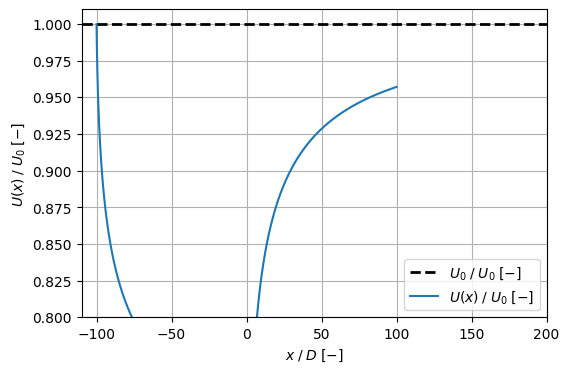

u_mean: 7.772599967103804
T: 54.17195577694578  MN
---------- 100 D ---------- 

c_t:     0.00641      [-]
N_wt:    233          [-]
T:       54171956     [kg·m·s⁻²]

u_s_2:   0.26986      [-]
u_s_3:   0.04282      [-]

A:       1010000     [m²]
h_f:     100         [m]
w_f:     10100        [m]

A_2:     2244370      [m²]
A2_A:    2.2          [-]
h_f_2:   149         [m]
w_f_2:   15056         [m]

A_3:     10789434     [m²]
A3_A2:   4.80733     [-]
h_f_3:   327         [m]
w_f_3:   33011         [m]

kx_h:      0.00889    [-]
kx_w:      0.89776    [-]
k_h:       88       [m]
k_w:       8977       [m]


In [178]:
d = 100 * D

l_f = int(10000)
w_f = int(10000 + (2*D/2))

x_1 = -l_f
x_2 = 0
x_3 = d

x, u_tdm, c_t, h_1, idx1, idx2 = calculate_wind_speed(x_1, x_2, x_3, z_H, D, C_T, s_d, s_c)

h_f = int(h_1[x_2] * d/l_f)

u_s_2 = (U_0 - u_tdm[idx2][0]) / U_0

u_s_3 = (U_0 - u_tdm[-1]) / U_0

N_wt = int( (l_f+s_d)/s_d * (w_f+s_c-(2*D/2))/s_c )

u_mean = np.mean(u_tdm[:np.argmax(idx2)])
print('u_mean:', u_mean)
T = 1/2 * rho * C_T * np.pi*(D**2)/4 * u_mean**2 * N_wt
print('T:', T/1e6, ' MN')

# Evt., hvad ville resultatet være, hvis TDM hastighederne var det samme som PyW?
# Lin. vs WeightedSum integrals?
# Forklar i rapporten hvorfor momentum er sammenligningsgrundlag
# nu_w_star forhold til TI ved hub height

A = w_f * h_f
A_2 = T / (rho * U_0**2 * (1 - u_s_2)*u_s_2)
A2_A = A_2 / A

A_3 = A_2 * ((1 - u_s_2)*u_s_2) / ((1 - u_s_3)*u_s_3)

A3_A2 = A_3 / A_2

ar = w_f / h_f

h_f_2 = np.sqrt(A_2 / ar)
w_f_2 = np.sqrt(A_2 * ar)

h_f_3 = np.sqrt(A_3 / ar)
w_f_3 = np.sqrt(A_3 * ar)

kx_h = (h_f_3 - h_f_2) / 2 / d
kx_w = (w_f_3 - w_f_2) / 2 / d

k_h = int( kx_h * d )
k_w = int( kx_w * d )

'''fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x/D, h_1)
plt.grid(True)
plt.show()'''

print(f'---------- {d/D:.0f} D ---------- \n')

print(f'c_t:     {c_t:.5f}      [-]')
print(f'N_wt:    {N_wt:.0f}          [-]')
print(f'T:       {T:.0f}     [kg·m·s⁻²]\n')

print(f'u_s_2:   {u_s_2:.5f}      [-]')
print(f'u_s_3:   {u_s_3:.5f}      [-]\n')

print(f'A:       {A:.0f}     [m²]')
print(f'h_f:     {h_f:.0f}         [m]')
print(f'w_f:     {w_f:.0f}        [m]\n')

print(f'A_2:     {A_2:.0f}      [m²]')
print(f'A2_A:    {A2_A:.1f}          [-]')
print(f'h_f_2:   {h_f_2:.0f}         [m]')
print(f'w_f_2:   {w_f_2:.0f}         [m]\n')

print(f'A_3:     {A_3:.0f}     [m²]')
print(f'A3_A2:   {A3_A2:.5f}     [-]')
print(f'h_f_3:   {h_f_3:.0f}         [m]')
print(f'w_f_3:   {w_f_3:.0f}         [m]\n')

print(f'kx_h:      {kx_h:.05f}    [-]')
print(f'kx_w:      {kx_w:.05f}    [-]')
print(f'k_h:       {k_h:.0f}       [m]')
print(f'k_w:       {k_w:.0f}       [m]')

# Save to CSV

In [179]:
y_meas = np.linspace(0 - k_w, w_f + k_w, w_f+(2*k_w)+1)
U = np.full_like(y_meas, u_tdm[-1])

In [180]:
data = pd.DataFrame({
    "y_wake": y_meas / D,
    "U_norm": U / U_0,
    "kx_w": kx_w,
})
data.to_csv(f"../ArbitraryLayouts/ValidationData/{int(d / D)}D.csv", index=False)